# Import Libraries

In [ ]:
pip install pandasql

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from pandasql import sqldf
import plotly.express as px


In [68]:
pysqldf = lambda q: sqldf(q, globals())

# Read CSV files to dataframes

In [69]:
engagement_data = pd.read_csv(r'C:\Users\Public\Downloads\engagement_data.csv')
onboarding_data = pd.read_csv(r'C:\Users\Public\Downloads\onboarding_data.csv')


# SQL Queries for Data Manipulation - Onboarding Data

In [70]:
query = """

SELECT *,
        DENSE_RANK() OVER (PARTITION BY  funnel_name,month_ ORDER BY total_users DESC) AS row_num

FROM (

SELECT COUNT(DISTINCT id) as total_users,
        funnel_name,
        event_name,
        SUBSTR(REPLACE(date_,'-',''),1,6) as month_


FROM onboarding_data

WHERE id IS NOT NULL 
and funnel_name = 'guest_onboarding_funnel'
GROUP BY funnel_name,
         event_name,
         substr(REPLACE(date_,'-',''),1,6)
)

;
"""


# FINAL QUERY RUN!!!
onboarding_guest = pysqldf(query)
onboarding_guest

,total_users,funnel_name,event_name,month_,row_num
0,876,guest_onboarding_funnel,entered_dashboard,202201,1
1,251,guest_onboarding_funnel,grade_screen_launch,202201,2
2,235,guest_onboarding_funnel,country_screen_launch,202201,3
3,633,guest_onboarding_funnel,entered_dashboard,202202,1
4,224,guest_onboarding_funnel,country_screen_launch,202202,2
5,186,guest_onboarding_funnel,grade_screen_launch,202202,3
6,35,guest_onboarding_funnel,entered_dashboard,202203,1
7,14,guest_onboarding_funnel,grade_screen_launch,202203,2
8,13,guest_onboarding_funnel,country_screen_launch,202203,3


In [71]:
query2 = """
SELECT *,
        DENSE_RANK() OVER (PARTITION BY  funnel_name,month_ ORDER BY total_users DESC) AS row_num

FROM (

SELECT COUNT(DISTINCT id) as total_users,
        funnel_name,
        event_name,
        SUBSTR(REPLACE(date_,'-',''),1,6) as month_


FROM onboarding_data
WHERE id IS NOT NULL
GROUP BY funnel_name,
         event_name,
         substr(REPLACE(date_,'-',''),1,6)
)
WHERE funnel_name = 'registered_onboarding_funnel'
GROUP BY month_,total_users, funnel_name, event_name
;
"""

onboarding_registered = pysqldf(query2)
onboarding_registered


,total_users,funnel_name,event_name,month_,row_num
0,1188,registered_onboarding_funnel,first_app_open,202201,1
1,991,registered_onboarding_funnel,phone_entered,202201,2
2,947,registered_onboarding_funnel,otp_verified,202201,3
3,824,registered_onboarding_funnel,user_signed_up,202201,4
4,813,registered_onboarding_funnel,name_screen_launch,202201,5
5,742,registered_onboarding_funnel,gender_screen_launch,202201,6
6,691,registered_onboarding_funnel,grade_screen_launch,202201,7
7,1099,registered_onboarding_funnel,first_app_open,202202,1
8,722,registered_onboarding_funnel,phone_entered,202202,2
9,701,registered_onboarding_funnel,gender_screen_launch,202202,3


# FUNNEL VISUALIZATION FOR GUEST AND REGISTERED USERS

In [72]:
#FUNNEL FOR Onboarding Registered Funnel

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'January 2022',
    y = onboarding_registered[(onboarding_registered['month_'] == '202203')]['event_name'],
    x = onboarding_registered[(onboarding_registered['month_'] == '202203')]['total_users'],
    textinfo = "value+percent initial",
marker = {"color": ["#04345C", "#10564F", "#21B6A8","#1E77BD", "#BAD3E4", "#18A558", "#A3EBB1"]}))

In [73]:
#FUNNEL FOR Onboarding Guest Funnel

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'January 2022',
    y = onboarding_guest[(onboarding_guest['month_'] == '202203')]['event_name'],
    x = onboarding_guest[(onboarding_guest['month_'] == '202203')]['total_users'],
    textinfo = "value+percent initial",
marker = {"color": ["#04345C", "#10564F", "#21B6A8","#1E77BD", "#BAD3E4", "#18A558", "#A3EBB1"]}))

# MoM Percentage Change

In [74]:
query3 = """




SELECT first_app_open as step_1,
    CASE WHEN phone_entered is null then first_app_open ELSE phone_entered END AS step_2,
       CASE WHEN otp_verified is null then phone_entered ELSE otp_verified END AS step_3,
       CASE  WHEN user_signed_up is null then otp_verified ELSE user_signed_up END AS step_4,
       CASE     WHEN name_screen_launch is null then user_signed_up ELSE name_screen_launch END AS step_5,
        CASE    WHEN gender_screen_launch is null then name_screen_launch ELSE gender_screen_launch END AS step_6,
        CASE    WHEN grade_screen_launch is null then gender_screen_launch  ELSE grade_screen_launch END AS step_7

FROM (

SELECT  MAX(CASE WHEN row_num = 1 then total_users ELSE NULL END) AS first_app_open,
        MAX(CASE WHEN row_num = 2 then total_users ELSE NULL END) AS phone_entered,
        MAX(CASE WHEN row_num = 3 THEN total_users ELSE NULL END) AS otp_verified,
        MAX(CASE WHEN row_num = 4 THEN total_users ELSE NULL END) AS user_signed_up,
        MAX(CASE WHEN row_num = 5 THEN total_users ELSE NULL END) AS name_screen_launch,
        MAX(CASE WHEN row_num = 6 THEN total_users ELSE NULL END) AS gender_screen_launch,
        MAX(CASE WHEN row_num = 7 THEN total_users ELSE NULL END) AS grade_screen_launch,
        month_

FROM (

SELECT *,
        DENSE_RANK() OVER (PARTITION BY  funnel_name,month_ ORDER BY total_users DESC) AS row_num

FROM (

SELECT COUNT(DISTINCT id) as total_users,
        funnel_name,
        event_name,
        SUBSTR(REPLACE(date_,'-',''),1,6) as month_


FROM onboarding_data 
WHERE id IS NOT NULL
GROUP BY funnel_name,
         event_name,
         substr(REPLACE(date_,'-',''),1,6)
)

)
WHERE funnel_name = 'registered_onboarding_funnel'
GROUP BY month_
)
;

"""

MoM_registered = pysqldf(query3)
MoM_registered

,step_1,step_2,step_3,step_4,step_5,step_6,step_7
0,1188,991,947,824,813,742,691
1,1099,722,701,689,678,557,557
2,74,37,33,27,26,22,22


In [79]:
query4 = """
SELECT COUNT(DISTINCT id) total_users,
        ROUND(AVG(time_spent),2) AS avg_time_spent,
        activity_type,
        month_
FROM (


SELECT *,
        CASE WHEN date LIKE 'Feb%' THEN 'Feb'
             WHEN date LIKE 'Jan%' THEN 'Jan'
             ELSE NULL END AS month_
        

FROM engagement_data

)

GROUP BY month_ ,
            activity_type

;
"""

engagement_overall = pysqldf(query4)
engagement_overall

,total_users,avg_time_spent,activity_type,month_
0,391,1.16,Live Practice Game,Feb
1,153,0.00,enter_group,Feb
2,849,0.00,exit_group_section - post_details,Feb
3,514,2.45,homework,Feb
4,979,0.00,join_group,Feb
5,991,124.98,join_session_live - Scheduled 1:n,Feb
6,414,65.82,join_session_live - Scheduled Competition,Feb
7,684,15.19,join_session_replay - Scheduled 1:n,Feb
8,210,0.02,quizon,Feb
9,193,0.98,Live Practice Game,Jan


<AxesSubplot:ylabel='activity_type'>

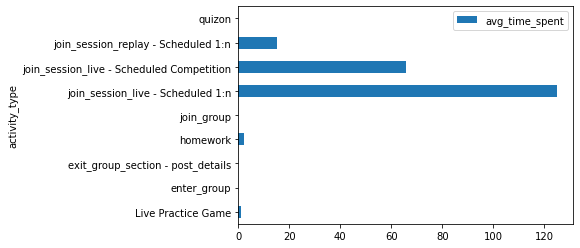

In [94]:
#create bar chart
engagement_overall[(engagement_overall['month_'] == 'Feb')].plot(kind='barh' , x='activity_type', y='avg_time_spent')

